In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.contingency import margins
import math
import scipy
import seaborn as sns

### Polynomial regression

We will write a method `gen_sine(N)` that generates toy data. The method have a parameter $N$, and return $N$-dimensional vectors $\bf{x}$ and $\bf{t}$, where $\bf{x}$ contains evenly spaced values from (0,1), and the elements $t_i$ of $\bf{t}$ are distributed according to:
$$t_i \sim \mathcal{N}(\mu_i, \sigma^2),$$
with the mean given by $\mu_i = \sin( 2 \pi x_i)$ and the standard deviation $\sigma=0.25$. Here $x_i$ is the $i$-th element of $\bf{x}$


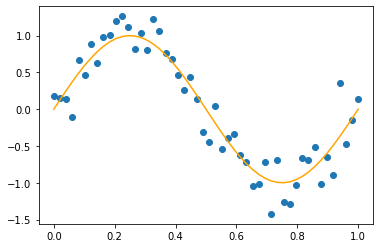

In [2]:
def gen_sine(n):
    t_values = []
    t_line = []
    x_axis = np.linspace(0, 1, n)
    for i in x_axis:
        mean = math.sin(2*math.pi*i)
        t_values.append(np.random.normal(mean, 0.25))
        t_line.append(math.sin(2*math.pi*i))

    return t_values, x_axis, t_line
  
t_values, x_axis, t_line = gen_sine(50)

plt.scatter(x_axis, t_values)
plt.plot(x_axis, t_line, color = 'orange')
plt.show()

Now we will write a function `fit_polynomial(x, t, M)` that finds the exact solution of the maximum-likelihood of an _unregularized_ $M$-th order polynomial for some dataset `x`. The error function to minimize w.r.t. $\bf{w}$ is:
$E(\bf{w}) = \frac{1}{2} (\bf{\Phi}\bf{w} - \bf{t})^T(\bf{\Phi}\bf{w} - \bf{t})$,
where $\bf{\Phi}$ is the _feature matrix_ (or _design matrix_), and $\bf{t}$ is the vector of target values. This method return a vector $\bf{w}$ with the maximum-likelihood parameter estimates. 

In [3]:
def fit_polynomial(x,t,M, n):
    
  t_vector = np.array(t)
  Phi = np.ones((n,M+1))

  for i in range(M+1):
    Phi[:,i] = x**i

  w = np.dot(np.dot(np.linalg.inv(np.dot(Phi.T, Phi)), Phi.T), t_vector)

  return w

In [4]:
w = fit_polynomial(x_axis, t_values, 3, 50)
print(w)

[ -0.20646573  12.55065445 -36.64368883  24.57556434]


In [5]:
def prediction(x,M,w):
    
  p_value = 0
  for i in range(M+1):
    p_value = w[i]*x**i + p_value

  return  p_value

We sample from a dataset with $N=50$, and fit four polynomials with $M \in (0,2,3,20)$. Then we plot the prediction function, along with the data and the original sine function. The optima coefficients are printed below each graph. 

w = [-0.00106323]


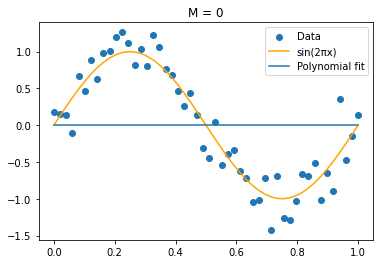

w = [ 0.94810473 -2.04626863  0.21965768]


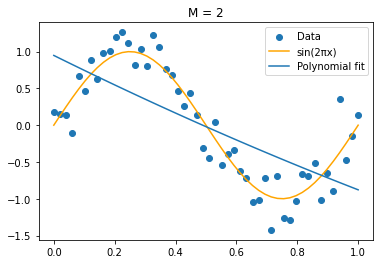

w = [ -0.20646573  12.55065445 -36.64368883  24.57556434]


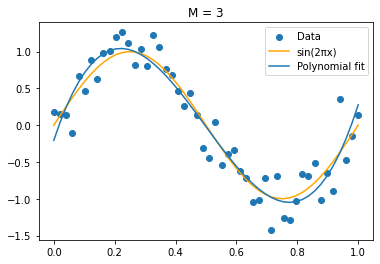

w = [ 5.15702361e-01 -1.15169707e+01  1.35904053e+02  4.50374712e+02
 -6.81064262e+03 -4.92604651e+03  2.40841998e+05 -1.02601357e+06
  1.79172945e+06 -8.79017950e+05 -1.19430956e+06  1.45964975e+06
 -8.99812892e+05  2.04674140e+06 -1.62544161e+06 -7.36857901e+05
  9.23963242e+04  1.17927347e+06  5.30281269e+05 -1.54575006e+06
  5.77451689e+05]


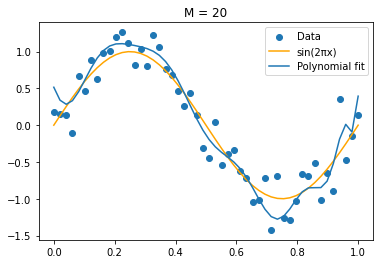

In [6]:
x_train = x_axis
t_train = t_values
M = [0,2,3,20]
for i in M:
  w = fit_polynomial(x_train,t_train, i, 50)
  print('w =',w)
  predictions = []
  for x in x_axis:
    predictions.append(prediction(x,i, w))

  plt.scatter(x_axis, t_values, label = 'Data')
  plt.plot(x_axis, t_line, color = 'orange', label = 'sin(2πx)')
  plt.plot(x_axis, predictions, label = 'Polynomial fit')
  plt.title('M = '+str(i))
  plt.legend()
  plt.show()

Clearly we are getting the best fit for $M = 3$. As $M$ increases the $\bf{w}$ coefficients are increased too like: $\bf{w_{coeff}}$ = $M + 1$. This is because for $M = 2$ for example the polynomial equation requires three $\bf{w}$ coefficients. $y = \bf{w_0} + \bf{w_1}x + \bf{w_2}x^2$

We will generate some additional data to use as test data to make sure that our model is not overfitting. We will fit polynomials with $M \in \text{range}(0,10)$. For each model we calculate the reduced chi-square statistic.
$$
\chi_\nu^2 = \frac{\chi^2}{\nu},
$$
$$
\chi^2 = \sum_i \frac{(O_i - C_i)^2}{\sigma_i^2}.
$$


In [7]:
def chi2(predictions, t_values):
    chi2 = []
    for i in range(len(predictions)):
        chi2.append(((predictions[i] - t_values[i])**2)/0.25**2)
    return sum(chi2)/40

In [8]:
chi2_values = []
for M in range(0,11):
  w = fit_polynomial(x_axis,t_values, M, 50)

  predictions = []
  for x in x_axis:
    predictions.append(prediction(x,M,w))

  chi2_values.append(chi2(predictions, t_values))

In [9]:
t_values_new, x_axis_new, t_line_new = gen_sine(50)
chi2_values_new = []
for M in range(0,11):
  w = fit_polynomial(x_axis_new,t_values_new, M, 50)

  predictions = []
  for x in x_axis:
    predictions.append(prediction(x,M, w))

  chi2_values_new.append(chi2(predictions, t_values_new))

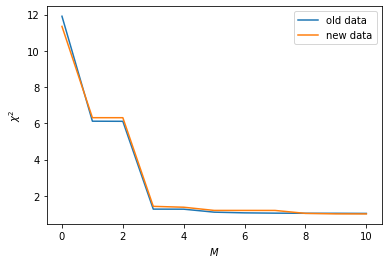

In [10]:
plt.plot(chi2_values, label = 'old data')
plt.plot(chi2_values_new, label = 'new data')
plt.xlabel('$M$')
plt.ylabel('$\chi ^2$')
plt.legend()
plt.show()

As expected for higher $M$ values the $\chi_\nu^2$ values are getting lower. This is because for large $M$ the polynomial function "overfits" to the data and in essence passes as close as possible from every single data point of the data, hence the low $\chi_\nu^2$ value. 

#### Regularized Regression

We will write a method that finds the regularized $M$-th order polynomial for some dataset $\bf{x}$. This method include the regularizer weight $\lambda$ as a parameter and return a vector $\bf{w}$ with the maximum-likelihood parameter estimates. 

In [11]:
def fit_polynomial_reg(x,t,M,n,λ):
    
  t_vector = np.array(t)
  Phi = np.ones((n,M+1))

  for i in range(M+1):
    Phi[:,i] = x**i

  w = np.dot(np.dot(np.linalg.inv(np.dot(λ, np.eye(M+1))+np.dot(Phi.T, Phi)), Phi.T), t_vector)

  return w

Now we are going to use our ``` gen_sine``` method to generate 10 datapoints, under the same conditions as before. Fit  polynomials of $M \in (0,2,3,9)$ for values $\lambda \in (0,10^{-5}, 10^{-3}, 10^{-2}, 100)$.

Plots for λ =  0


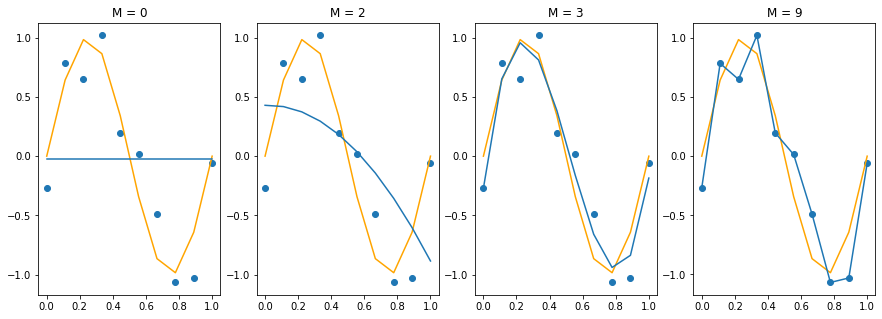

Plots for λ =  1e-05


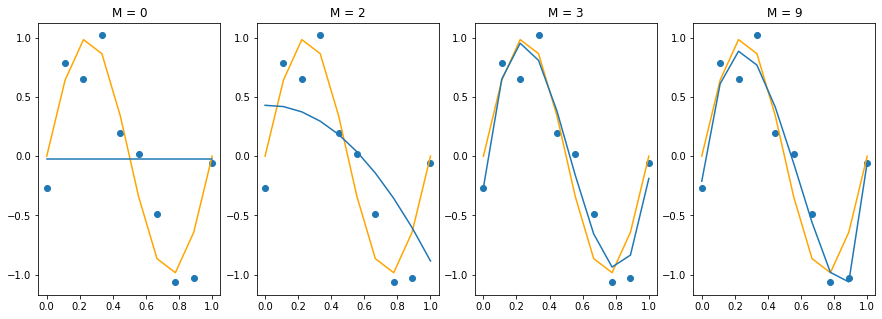

Plots for λ =  0.001


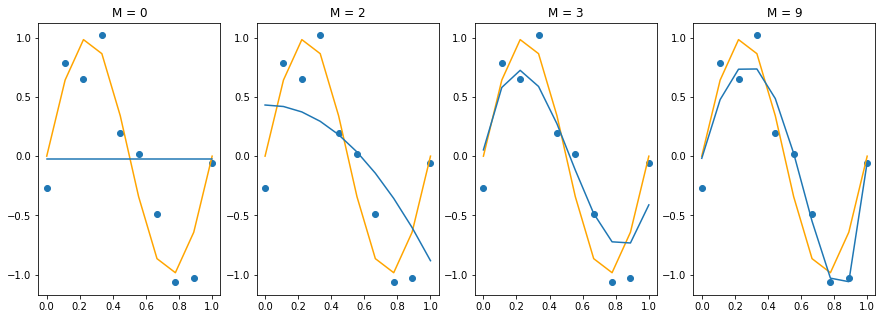

Plots for λ =  0.01


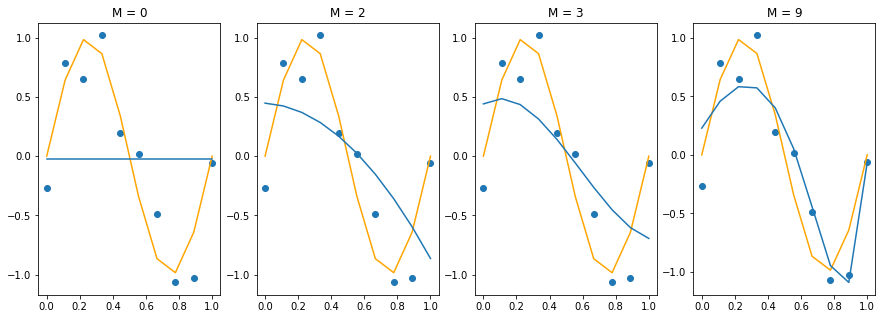

Plots for λ =  100


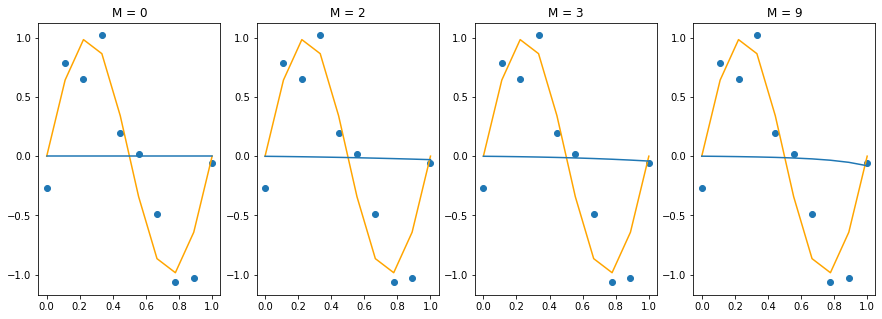

In [12]:
M = [0,2,3,9]
λ = [0, 10**(-5), 10**(-3), 10**(-2), 100]

t_values10, x_axis10, t_line10 = gen_sine(10)


def plot_reg(x_axis,t_values,t_line,M,n,λ, k, axs):

    w = fit_polynomial_reg(x_axis,t_values,M,n,λ)

    predictions = []
    for x in x_axis:
      predictions.append(prediction(x,M, w))
    
    
    axs[k].scatter(x_axis, t_values, label = 'data')
    axs[k].plot(x_axis, t_line, color = 'orange', label = 'sin(2πx)')
    axs[k].plot(x_axis, predictions, label = 'polyfit')
    axs[k].title.set_text('M = '+str(M))

for l in λ: 
  plt.show()
  k = 0
  print('Plots for λ = ',l)
  fig, axs = plt.subplots(1,4, figsize = (15,5))
  for i in M:
    plot_reg(x_axis10, t_values10, t_line10, i ,10, l, k, axs)
    k += 1

We can see that as the $\lambda$ value increases the polynomial fit looses the ability to "fit" on the data. This is expected because the quantity $\lambda\bf{I}$ is added to the solution of $\bf{w}$ coefficients and gives an invetrted matrix, so the higher the value of $\lambda$ the lower the coefficients $\bf{w}$ and the more "straight" the polynomian fit line. 

For $M = 9$ we have the best fit for $\lambda = 0.001$